In [1]:
#from data_generator import dgen, pack_by_value, downscale_nsave, Camera_source, data_generator, dir_source, resize_tuple
from sources.Camera import thr_camera
#from fit_pca import plot_images_table, get_pca_sk_transformer

import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

import os, time, shutil

from IPython import display

#%load_ext autoreload
#%autoreload 2

In [2]:
try:
    cam.release()
except:pass
cam = cv2.VideoCapture(1)
cam.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25)
        # 10 was found to be the smallest value
cam.set(cv2.CAP_PROP_EXPOSURE, -9)
print("Param::auto exp?",cam.get(cv2.CAP_PROP_AUTO_EXPOSURE))
print("Param::exp time", cam.get(cv2.CAP_PROP_EXPOSURE))

cam.isOpened()

Param::auto exp? 0.0
Param::exp time -7.0


True

## Just view the camera

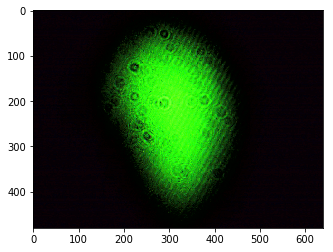

KeyboardInterrupt: 

In [15]:
gen, p = thr_camera(cam, q_size=0)
im_prev = np.zeros((10,10))
for im in gen:
    if im is not None:
        im_prev = im
        continue
    else:
        time.sleep(.4)
        display.clear_output()
        plt.imshow(im_prev)
        plt.show()
    

In [5]:
# an optional path of where to save data
from webvis import Vis
vis = Vis(ws_port=7700, vis_port=81)

ModuleNotFoundError: No module named 'webvis'

In [6]:
vis.vars['test']='hello'

NameError: name 'vis' is not defined

In [3]:
#from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
import server
server.start()


Mon Jul 22 15:03:16 2019 Server Starts - :80


<DummyProcess(Thread-6, started 3736)>

In [4]:
rot_value = [0]
def rot_gen():
    while True:
        yield rot_value[0]

server.bind(rot_value)

In [5]:
from data_generator import resize_gen
import server

def time_gen():
    start = time.time()
    while True:
        yield time.time() - start
        
def dir_saver(gen,path):
    num = 0
    for x,y in gen:
        for i,im,label in zip(range(len(x)),x,y):
            num+=1
            impath = path+str(num)+"_"+str(label)+'_'+str(i)+'.png'
            #print('writing image to', impath)
            cv2.imwrite(impath,im)
        yield x,y
            
def packer(gen,y_gen,delay=0.1,size=12):
    """ appends and yields if got none """
    pack= []
    pack_y = []
    for im in gen:
        if im is not None:
            y = next(y_gen)
            pack.append(im)
            pack_y.append(y)
            continue
        else:
            time.sleep(delay)
            if len(pack)>size:
                yield pack,np.array(pack_y)
                pack=[]
                pack_y=[]
                
def pipeline():
    gen, p = thr_camera(cam)
    res = resize_gen(gen, factor=0.3)
    xy = packer(res, rot_gen())
    
    xy = dir_saver(xy,path='../data/img3_stripes/')
    #xy = ((x, np.ones(len(x))*y) for x,y in xy)
    
    return xy
    

In [6]:
transformer = IncrementalPCA(
    n_components=10,
    batch_size=200
)
#train_gen = pipeline()
def remove_random(arr, count):
    count = min(len(arr),count)
    for i in range(count):
        arr.pop(random.randrange(len(arr)))
    return arr
    
def cached_random_gen(gen, cache_size=1000):
    cache = []
    for x,y in gen:
        if len(cache)>cache_size:
            cache = remove_random(cache, count=len(x))
        for xy in zip(x,y):
            cache.append(xy)
        xs = [x for x,y in cache]
        ys = [y for x,y in cache]
        xs,ys = np.array(xs),np.array(ys)
        yield xs,ys
        
def transformed_gen(gen):
    for im, y in gen:
        #vis.vars['img'] = im[0]
        #print('len',len(im), 'sh', im[0].shape)
        vec = np.array([i.flatten() for i in im])
        #print(vec.shape)
        transformer.partial_fit(vec)
        x = transformer.transform(vec)
        var = transformer.explained_variance_ratio_
        #print(sum(var),var[:5])
        y = y
        yield x, y
        
def printer(gen):
    for x,y in gen:
        print('shapes',x.shape,y.shape)
        print('means',np.mean(x), np.mean(y))
        print('stds',np.std(x), np.std(y))
        vis.vars['ys'] = y.tolist()
        vis.vars['sampl'] = x[0].tolist()
        yield x,y
    

In [8]:
for x,y in pipeline():
    if abs(np.mean(y) - 2*0.16/13-0.1) < 10**(-8):
        time.sleep(2)
    print(np.mean(y))

0.12207079352807997
0.12230934894251477
0.12251256281407034
0.12271577668562594
0.12295433210006072
0.12317521674305598
0.12336959522889172
0.12357280910044728
0.12385671949491048
0.12406759070075657
0.12428847534375173
0.12456237230106575
0.1246153846153846
0.1246153846153846
0.1246153846153846
0.1246153846153846
0.10006660521542622
0.10030040311447344
0.10050302796031439
0.10074217240046388
0.1009419880467426
0.10116627091501465
0.10140482632944946
0.10160804020100501
0.10180241868684081
0.1020321387155558
0.10227069412999058
0.10252148315542212
0.10271178377092564
0.102892569355654
0.10309238500193277
0.10331326964492792
0.10353415428792312
0.10375503893091835
0.10394873777169875
0.10417913744546914
0.10444478804277799
0.10465285004906187
0.10493956964308723
0.10514219448892817
0.10536307913192337
0.1056193053177978
0.10585786073223258
0.10606107460378816
0.10629895037316764
0.10650284388977857
0.1067176117272754
0.10696817420435513
0.10723142338913502
0.10744075406618894
0.10766911

0.10288917113037714
0.10309238500193277
0.10328676348776848
0.10352056138681573
0.10376795218697038
0.10399359434535316
0.10420564360262853
0.10439594421813211
0.10465624827433873
0.1048948036887735
0.10513811661859594
0.10537191451764319
0.10556629300347894
0.10584902534651278
0.10606107460378816
0.10630021904393766
0.10655585620409744
0.10675023468993317
0.10698403258898043
0.10721851013308302
0.10742172400463858
0.10761610249047437
0.10787844548184711
0.10809729118967619
0.10828759180517977
0.1084819702910155
0.10872936109117012
0.10895908111988517
0.10915345960572091
0.10934783809155667
0.1095911510213791
0.10981951175998336
0.11000981237548692
0.11022254127781769
0.11046109669225247
0.11069081672096746
0.11088519520680329
0.1110754958223068
0.11130045833563419
0.1115655199072285
0.1117952399359435
0.11198961842177921
0.11221050306477445
0.1124456602539324
0.11266110773648462
0.11285480657726504
0.11306753547959579
0.11330137868831335
0.11354876948846795
0.11378320172290025
0.11397

0.10927715500579822
0.10952454580595285
0.1097148464214564
0.1099432071600607
0.11016069357777902
0.11039041360649401
0.11059362747804961
0.11080907496060186
0.11100889060688057
0.11125628140703518
0.11145065989287097
0.11167154453586614
0.11187475840742171
0.11212214920757636
0.11231244982307988
0.1125462477221271
0.11276713236512234
0.11295947191579196
0.1131776832882361
0.11343332044839587
0.11365406916237995
0.11384436977788351
0.11407653652879786
0.11429157622431685
0.11453833268908645
0.11475781273230058
0.11503782649511296
0.11527225872954518
0.11553260809542214
0.11575349273841733
0.1159896920499936
0.11624827433872661
0.1164514882102822
0.11664940085040591
0.11690209288199238
0.11712297752498756
0.11731735601082338
0.11756474681097798
0.11781213761113259
0.11801535148268823
0.11823623612568337
0.11843061461151913
0.11865149925451438
0.11886830602717732
0.11908715173500638
0.11927745235050996
0.11954387321221495
0.1197722339508192
0.11997680711248547
0.12021944039725257
0.12045

0.11502423359400556
0.11521453420950908
0.1154089126953449
0.11562368053284174
0.11587718813849467
0.11608040201005025
0.11627478049588603
0.11652760845648359
0.1167430559390358
0.11693675477981627
0.11716892153073057
0.11738803909658187
0.11763071769101922
0.11787874282655884
0.11805952841128722
0.11829867285143666
0.1185872954516171
0.11878267075020071
0.1189960792975868
0.11924347009774149
0.11948202551217628
0.11973353949233347
0.11998564249820529
0.12020652714120054
0.12040022598198091
0.12065713181291073
0.12085151029874651
0.12108594253317873
0.1213286211276161
0.12152299961345189
0.12171737809928765
0.12193826274228282
0.12218905176771436
0.12238886741399306
0.12258324589982879
0.12283063669998348
0.12306035672869846
0.12328124137169368
0.12350212601468884
0.12369650450052462
0.12392078736879665
0.12416477994367439
0.12436799381523002
0.12458887845822518
0.1246153846153846
0.1246153846153846
0.1246153846153846
0.1098461538461539
0.10020933067705393
0.10042409851455078
0.1006679

0.12293666132862112
0.12313103981445694
0.12340493677177099
0.12362582141476615
0.12387321221492079
0.12406351283042436
0.12428847534375173
0.12448217418453214
0.1246153846153846
0.1246153846153846
0.1246153846153846
0.1246153846153846
0.10005301231431883
0.1002473908001546
0.10050361698602905
0.10068916008614501
0.10091344295441709
0.10115449040072158
0.10141366171516926
0.10160804020100501


KeyboardInterrupt: 

In [26]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam

In [27]:
#layers
inp_s = 10
first = 10
second = 5
out = 1

In [28]:
inp = Input(shape = [inp_s])
x = BatchNormalization()(inp)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.00001, amsgrad=False)


model.compile(loss='mse',optimizer=opt)

In [29]:
def shuffler(gen):
    for x,y in gen:
        a = list(zip(x,y))
        random.shuffle(a)
        x,y = [x for x,y in a], [y for x,y in a] 
        x,y = np.array(x),np.array(y)
        yield x,y

In [46]:
pipe = pipeline()

In [31]:
x,y = next(pipe)
x[0].shape,y[0].shape

((144, 192, 3), ())

In [32]:
gen =    shuffler(
cached_random_gen(
transformed_gen(
pipe
) ) )

x,y=  next(gen)
print(x.shape)
print(y.shape,y)
server.VAL

(13, 10)
(13,) [0.1108852 0.1108852 0.1108852 0.1108852 0.1108852 0.1108852 0.1107615
 0.1107615 0.1108852 0.1107615 0.1107615 0.1107615 0.1107615]


[0.11100889060688057]

In [33]:
model.fit_generator(
    gen,
    steps_per_epoch=100,
    epochs = 20,
 )
         # validation_data=(X_train[validate], y_train[validate]))

Epoch 1/20
  3/100 [..............................] - ETA: 2:54 - loss: 0.089 - ETA: 2:14 - loss: 0.078 - ETA: 2:08 - loss: 0.0726OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\videoio\src\cap_msmf.cpp:1077: error: (-215:Assertion failed) videoSample in function 'SourceReaderCB::Wait'

 21/100 [=====>........................] - ETA: 2:06 - loss: 0.063 - ETA: 2:03 - loss: 0.056 - ETA: 1:59 - loss: 0.050 - ETA: 1:57 - loss: 0.045 - ETA: 1:56 - loss: 0.041 - ETA: 1:54 - loss: 0.037 - ETA: 1:53 - loss: 0.035 - ETA: 1:51 - loss: 0.033 - ETA: 1:50 - loss: 0.031 - ETA: 1:49 - loss: 0.030 - ETA: 1:48 - loss: 0.028 - ETA: 1:46 - loss: 0.027 - ETA: 1:45 - loss: 0.026 - ETA: 1:44 - loss: 0.025 - ETA: 1:42 - loss: 0.025 - ETA: 1:41 - loss: 0.024 - ETA: 1:40 - loss: 0.023 - ETA: 1:38 - loss: 0.0233OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\videoio\src\cap_msmf.cpp:1077: error: (-215:Assertion failed) videoSample in function 'SourceReaderCB::Wait'

 25/100 [======>...............

KeyboardInterrupt: 

[0.77233797 0.08150325 0.06532057 0.01937622 0.01827156]


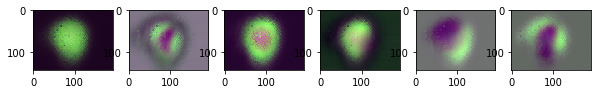

In [34]:
cmp = transformer.components_

cnt = 6
f, axs = plt.subplots(1,cnt,figsize=(10,15))
v0 = transformer.mean_
a = v0.reshape(144,192,3)
axs[0].imshow(a.astype(np.uint8))
for i, ax in enumerate(axs[1:]):
    v = cmp[i-1]
    a = v.reshape(144,192,3)
    a -= np.min(a)
    a *= 255/np.max(a)

    ax.imshow(a.astype(np.uint8))
print(transformer.explained_variance_ratio_[:5])

In [45]:
next(test_gen)

StopIteration: 

In [47]:
test_gen = (
cached_random_gen(
transformed_gen(
pipe
) ) )
#predictor = model.predict_generator(pca_ed)
for x,y in test_gen:
    x = np.array(x)/256
    pred = model.predict(x)
    print("True:", np.min(y.reshape(-1)), np.max(y), np.std(y))
    print("Predicted:",np.min(pred.reshape(-1)), np.max(pred), np.std(pred))
    print(np.sqrt(np.mean(np.square(y-pred))))


True: 0.11236954000773097 0.1126169308078856 8.656874677681037e-05
Predicted: 0.12079096 0.1208827 2.874492e-05
0.008401232835904394
True: 0.11236954000773097 0.11298801700811752 0.0002138820420681005
Predicted: 0.12079096 0.1208827 3.2123167e-05
0.008186653556907543
OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\videoio\src\cap_msmf.cpp:1077: error: (-215:Assertion failed) videoSample in function 'SourceReaderCB::Wait'

True: 0.11236954000773097 0.11335910320834945 0.00032415136288875844
Predicted: 0.12077616 0.1208827 3.473429e-05
0.007994067802430359
True: 0.11236954000773097 0.11360649400850406 0.00041440611745517897
Predicted: 0.120768346 0.1208827 3.63171e-05
0.007817329911061592
OpenCV(3.4.5) C:\projects\opencv-python\opencv\modules\videoio\src\cap_msmf.cpp:1077: error: (-215:Assertion failed) videoSample in function 'SourceReaderCB::Wait'

True: 0.11236954000773097 0.113977580208736 0.000517910929548246
Predicted: 0.12076382 0.1208827 3.602031e-05
0.0076404998868528865


KeyboardInterrupt: 

In [17]:
x,y = [],[]
for i in range(100):
    x_,y_ = next(test_gen)
    x.append(x_)
    y.append(y_)
x = np.concatenate(x)
y = np.concatenate(y)
print("mean", np.mean(y))
print("std", np.std(y))

mean 0.10896361614727793
std 0.006960099555604584


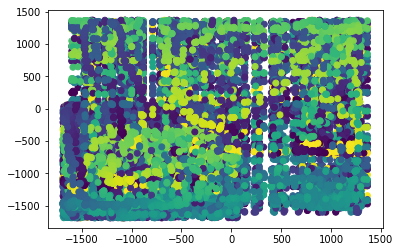

In [18]:
x = x[:,:2]
plt.scatter(*x.reshape(2,-1),c=y)

In [ ]:
from sklearn.externals import joblib # saving pca
_ = joblib.dump(pca, 'PCA'+str(n_components)+'.save')

In [ ]:
pca = joblib.load('PCA'+str(n_components)+'.save')

In [ ]:
transformed = pca.transform(X)

In [ ]:
transformed = transformed/transformed.max()


In [ ]:
angles = np.array([d[1] for d in data])
angles = angels - angels.min()
angles

In [ ]:
enc = OneHotEncoder()
enc.fit(angles.reshape(len(angles),1))
trAng = enc.transform(angles.reshape(len(angles),1))

In [ ]:
#X = [np.array(d.getdata()).flatten() for d in imgs]
X = np.array(X).reshape(len(X), 204, 256, 3)

import matplotlib.pyplot as plt
plt.imshow((X[0]).astype(np.uint8), interpolation='nearest')

In [ ]:
test = np.cumsum([0, 6, 7, 7, 7, 8, 7, 8, 7, 7, 6, 7, 7, 7])
train = np.delete(range(len(X)), test)

In [ ]:
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Input, Flatten, BatchNormalization
from keras.models import Model

In [ ]:
#layers
first = 20
second = 10
out = 1

In [ ]:
inp = Input(shape = (204, 256, 3))
x = MaxPooling2D((2, 2), padding='same')(inp)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((20, 20), padding='same')(x)
x = Conv2D(1, (2, 2), activation='relu', padding='same')(x)
#x = MaxPooling2D((10, 10), padding='same')(x)
x = Flatten()(x)
x = Dense(first, activation='relu')(x)
x = Dense(second, activation='relu')(x)
x = Dense(out, activation='relu')(x)
model = Model(inp, x)
model.compile(loss='mae', optimizer='adam')

In [ ]:
model.fit(X[train]/256, angles[train]%10/10, batch_size=4, epochs=300, shuffle=True, validation_data=(X[test]/256, angles[test]%10/10))

In [ ]:
pred = model.predict(X[test]/256)*10

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(range(len(pred)), pred[:, 0], 'ro-', ms=1)
plot.plot(range(len(pred)), angles[test]%10, 'bo-', ms=1)

In [ ]:
fig=plt.figure(figsize=(10, 10))
plot=fig.add_subplot(111)
plot.plot(angles[test]%10, pred[:, 0], 'ro', ms=10)

In [ ]:
import os
os.listdir('C:\\Users\\ЛФКИТ-3\\Documents\\quantTechLab\\data\\auto_rotate')

In [18]:
2*0.16/13+0.1 - 0.1246153846153846


2.7755575615628914e-17